Original candidates= (200, 2)
Reduced candidates to 200 promising ones using SVM.
Reduced candidates= (200, 2)
first point ei_vals[ 5 ]= 0.3080710092366788
seed_points=
 [[0.75351311 0.53814331]
 [0.19179872 0.53697208]
 [0.47903352 0.54114105]
 [0.03959288 0.52858926]
 [0.20390738 0.35335078]
 [0.49400576 0.52222003]
 [0.81027435 0.34179472]
 [0.75336542 0.3378542 ]
 [0.75830586 0.35978693]
 [0.11810523 0.36026388]]
seed=	 [0.75351311 0.53814331] 	EI= 0.30807194439121094
best_x=	 [0.75351311 0.53799786] 	EI= 0.30807194439121094
seed=	 [0.19179872 0.53697208] 	EI= 0.3080719422141569
seed=	 [0.47903352 0.54114105] 	EI= 0.30807194366395063
seed=	 [0.03959288 0.52858926] 	EI= 0.3080719411605742
seed=	 [0.20390738 0.35335078] 	EI= 0.3024694304245177
seed=	 [0.49400576 0.52222003] 	EI= 0.3080719437202194
seed=	 [0.81027435 0.34179472] 	EI= 0.3024694291932517
seed=	 [0.75336542 0.3378542 ] 	EI= 0.3024694295335222
seed=	 [0.75830586 0.35978693] 	EI= 0.30246942950669176
seed=	 [0.11810523 0.36

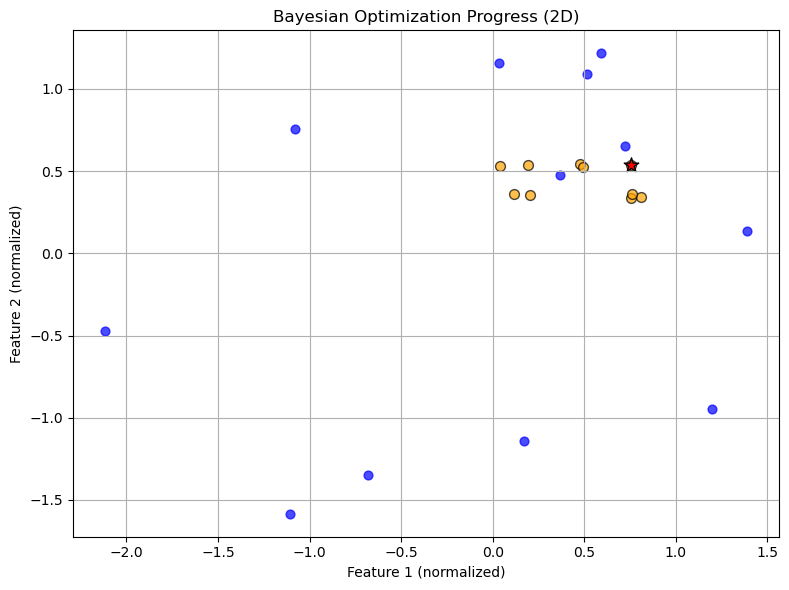

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import norm
from scipy.optimize import minimize


# ------------------------------------------------------------
# Load initial data
# ------------------------------------------------------------
X = np.load("initial_inputs.npy")        # shape (n0, d)
y = np.load("initial_outputs.npy")       # shape (n0,)

# ------------------------------------------------------------
# Append new information
# ------------------------------------------------------------
X = np.append(X,[[0.701438, 0.897524]], axis=0)  # Append week1 inputs
y = np.append(y, 4.907008577514035e-55)         # Append week1 outputs
X = np.append(X,[[0.605871, 0.208839]], axis=0)  # Append week2 inputs
y = np.append(y, -2.514581930414314e-56)         # Append week2 outputs

# Save the updated data
np.save("updated_inputs_PW2.npy", X)
np.save("updated_outputs_PW2.npy", y)

# ------------------------------------------------------------
# Normalise inputs and outputs
# ------------------------------------------------------------
x_scaler = StandardScaler()
Xn = x_scaler.fit_transform(X)

y_mean = y.mean()
y_std = y.std() if y.std() > 0 else 1.0
yn = (y - y_mean) / y_std                 # GP works better with normalized target


def visualize_iteration(Xn, seed_points, suggested_point):
    """
    Simple 2D visualization of current iteration:
    - Xn: existing normalized input data (n x 2)
    - seed_points: candidate points used for local optimization (m x 2)
    - suggested_point: final chosen query point (1 x 2)
    """
    if Xn.shape[1] != 2:
        print("This visualization works only for 2D input data.")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(Xn[:, 0], Xn[:, 1], c='blue', label='Existing points', s=40, alpha=0.7)
    plt.scatter(seed_points[:, 0], seed_points[:, 1], c='orange', label='Seed points', s=50, alpha=0.7, edgecolors='k')
    plt.scatter(suggested_point[0], suggested_point[1], c='red', label='Suggested point', s=120, marker='*', edgecolors='k')

    plt.title("Bayesian Optimization Progress (2D)")
    plt.xlabel("Feature 1 (normalized)")
    plt.ylabel("Feature 2 (normalized)")
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Fit a Gaussian Process surrogate
# ------------------------------------------------------------
d = X.shape[1]
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(d),
                                      length_scale_bounds=(1e-5, 1e5),
                                      nu=2.5)
kernel += WhiteKernel(noise_level=1e-6,
                      noise_level_bounds=(1e-10, 1e1))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=False,
                              n_restarts_optimizer=10,
                              random_state=0)
gp.fit(Xn, yn)

# ------------------------------------------------------------
# Add SVM to classify promising regions
# ------------------------------------------------------------
if len(yn) > 1:  # need at least two points for classification
    median_y = np.median(yn)
    labels = (yn >= median_y).astype(int)
    svm_clf = SVC(kernel='rbf', C=1.0)
    svm_clf.fit(Xn, labels)
else:
    svm_clf = None

# ------------------------------------------------------------
# Define Expected Improvement acquisition (for maximization)
# ------------------------------------------------------------
f_best = yn.max()
xi = 0.01     # exploration parameter

def predict_raw(x_raw):
    """Predict mean and std in normalized GP space for a raw input x_raw."""
    x = np.atleast_2d(x_raw)
    xn = x_scaler.transform(x)
    mu, sigma = gp.predict(xn, return_std=True)
    return mu.ravel(), sigma.ravel()

def expected_improvement_raw(x_raw, xi=xi):
    """Compute EI for a raw input x_raw."""
    mu, sigma = predict_raw(x_raw)
    sigma = np.maximum(sigma, 1e-9)       # avoid division by zero
    z = (mu - f_best - xi) / sigma
    ei = (mu - f_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)
    #print ("x_raw=", x_raw, "mu=", mu, "sigma=", sigma,"ei=",ei)
    return ei.ravel()[0]

# ------------------------------------------------------------
# Search for the next query point
# ------------------------------------------------------------
# Domain is assumed to be [0,1]^d (based on inspection of initial data)
bounds = [(0.0, 1.0)] * d

# Global random search to find good seeds
n_seeds = 200
rng = np.random.default_rng(1)
candidates = rng.uniform(0.0, 1.0, size=(n_seeds, d))
#Central limit theorm

print ("Original candidates=", candidates.shape)

if svm_clf is not None:
    candidates_n = x_scaler.transform(candidates)
    predicted_labels = svm_clf.predict(candidates_n)
    good_idx = np.where(predicted_labels == 1)[0]
    if len(good_idx) > 0:
        candidates = candidates[good_idx]
        print(f"Reduced candidates to {len(candidates)} promising ones using SVM.")

print ("Reduced candidates=", candidates.shape)

ei_vals = np.array([expected_improvement_raw(c) for c in candidates])
best_idx = np.argmax(ei_vals)
print ("first point ei_vals[",best_idx,"]=", ei_vals[best_idx])

# Take top few seeds for local optimisation
seed_points = candidates[np.argsort(-ei_vals)[:10]]
print ("seed_points=\n", seed_points)

best_x = None
best_val = -1.0
for s in seed_points:
    res = minimize(lambda xx: -expected_improvement_raw(xx),
                   x0=s,
                   bounds=bounds,
                   method="L-BFGS-B",
                   options={'maxiter':300})
    if res.success:
        val = -res.fun
        print ( "seed=\t", s, "\tEI=", val)
        #visualize_iteration(Xn, seed_points, best_x)
        if val > best_val:
            best_val = val
            best_x = res.x.copy()
            print ( "best_x=\t", best_x, "\tEI=", val )
        
        

# Fallback if optimizer fails
if best_x is None:
    best_x = candidates[best_idx]
    best_val = ei_vals[best_idx]

# ------------------------------------------------------------
# Report results
# ------------------------------------------------------------
suggested_point = np.atleast_1d(best_x)
mu_s, sigma_s = predict_raw(suggested_point.reshape(1, -1))

# Convert mean/std back to original y-scale
mu_orig = mu_s * y_std + y_mean
sigma_orig = sigma_s * y_std
next_query = "-".join([f"{xi:.6f}" for xi in suggested_point])

print("Suggested next query point (raw input space):", next_query)
print("Expected Improvement at this point (normalized):", best_val)
print("GP predicted mean at this point (original y scale):", mu_orig)
print("GP predicted stddev at this point (original y scale):", sigma_orig)

# Visualise
visualize_iteration(Xn, seed_points, best_x)